In [ ]:
# gather number of units per area from the data

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
ephys_sessions_path = r"D:\dr_ephys_sessions_list_2024_10_30_0.pkl"

#load from pickle
with open(ephys_sessions_path, 'rb') as f:
    ephys_sessions = pickle.load(f)

In [ ]:
n_units_per_area = {
    'session_id':[],
    'project':[],
    'area':[],
    'n_units_no_criteria':[],
    'metricsmedium_criteria':[],
    'n_units_strict_criteria':[],
    'grid_search_array':[],
    'isi_viol_values':[],
    'presence_ratio_values':[],
    'amplitude_cutoff_values':[],
}

isi_viol_values=np.arange(0,0.55,0.05)
presence_ratio_values=np.arange(0.9,1.01,0.01)
amplitude_cutoff_values=np.arange(0.01,0.11,0.01)

start_time=time.time()

for ss in ephys_sessions[:2]:
    session=DynamicRoutingSession(ss)
    session_info=npc_lims.get_session_info(ss)
    units=data_utils.load_trials_or_units(session,'units')
    unique_areas = units['structure'].unique()

    units_medium_criteria = units.query('isi_violations_ratio<=0.5 and presence_ratio>=0.9 and amplitude_cutoff<=0.1')
    units_strict_criteria = units.query('isi_violations_ratio<=0.1 and presence_ratio>=0.99 and amplitude_cutoff<=0.1')

    for area in unique_areas[:2]:

        vary_isi_violations_ratio = []
        vary_presence_ratio = []
        vary_amplitude_cutoff = []

        #make grid search an xarray
        grid_search=np.zeros((len(isi_viol_values),len(presence_ratio_values),len(amplitude_cutoff_values)))

        for iv,isi_viol in enumerate(isi_viol_values):
            for pr,presence_ratio in enumerate(presence_ratio_values):
                for ac,amplitude_cutoff in enumerate(amplitude_cutoff_values):
                    print(f"session {ss}, area {area}, isi_viol {isi_viol}, presence_ratio {presence_ratio}, amplitude_cutoff {amplitude_cutoff}")
                    units_vary_criteria = units.query('structure==@area and isi_violations_ratio<=@isi_viol and \
                                                      presence_ratio>=@presence_ratio and amplitude_cutoff<=@amplitude_cutoff')
                    grid_search[iv,pr,ac]=len(units_vary_criteria)

        n_units_per_area['session_id'].append(str(ss))
        n_units_per_area['project'].append(str(session_info.project))
        n_units_per_area['area'].append(area)
        n_units_per_area['n_units_no_criteria'].append(np.sum(units['structure']==area))
        n_units_per_area['n_units_medium_criteria'].append(np.sum(units_medium_criteria['structure']==area))
        n_units_per_area['n_units_strict_criteria'].append(np.sum(units_strict_criteria['structure']==area))
        n_units_per_area['grid_search_array'].append(grid_search)
        n_units_per_area['isi_viol_values'].append(isi_viol_values)
        n_units_per_area['presence_ratio_values'].append(presence_ratio_values)
        n_units_per_area['amplitude_cutoff_values'].append(amplitude_cutoff_values)

    print(f"session {ss} done, {time.time()-start_time:.2f} seconds elapsed")

n_units_per_area_df = pd.DataFrame(n_units_per_area)

In [ ]:
#save dataframe
savepath = r"D:\n_units_vary_metrics"
n_units_per_area_df.to_pickle(os.path.join(savepath,'n_units_per_area_sliding_rp.pkl'))

In [ ]:
#load dataframe
savepath = r"D:\n_units_vary_metrics"
n_units_per_area_df = pd.read_pickle(os.path.join(savepath,'n_units_per_area_1.pkl'))

In [ ]:
unique_areas = n_units_per_area_df['area'].unique()

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area"

for aa in unique_areas:
    fig,ax=plt.subplots(3,1,sharex=True)
    # max_n_units=n_units_per_area_df.query('area==@aa')['n_units_no_criteria'].max()
    # max_n_units=100
    n,xbins,patches=ax[0].hist(n_units_per_area_df.query('area==@aa')['n_units_no_criteria'],bins=20,color='b',alpha=0.5,label='no criteria')
    ax[1].hist(n_units_per_area_df.query('area==@aa')['n_units_medium_criteria'],bins=xbins,color='g',alpha=0.5,label='medium criteria')
    ax[2].hist(n_units_per_area_df.query('area==@aa')['n_units_strict_criteria'],bins=xbins,color='r',alpha=0.5,label='strict criteria')
    ax[1].set_ylabel('number of sessions')
    ax[2].set_xlabel('number of units')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    #save figure
    fig.suptitle(f"area {aa}")
    fig.tight_layout()
    if '/' in aa:
        aa=aa.replace('/','-')
    
    fig.savefig(os.path.join(savepath,'plots',f"{aa}.png"))
    plt.close(fig)


In [ ]:
n_units_per_area_df

In [ ]:
aa='ACAd'

area_df=n_units_per_area_df.query('area==@aa')

area_df

In [ ]:
# aa='ACAd'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area\fraction_of_units_by_criteria"

for aa in unique_areas:
    area_df=n_units_per_area_df.query('area==@aa and project=="DynamicRouting"')

    area_df['fraction_units_medium_criteria']=area_df['n_units_medium_criteria']/area_df['n_units_no_criteria']
    area_df['fraction_units_strict_criteria']=area_df['n_units_strict_criteria']/area_df['n_units_no_criteria']

    fig,ax=plt.subplots(1,1)
    #boxplot of fraction of units that pass medium and strict criteria
    area_df.boxplot(column=['fraction_units_medium_criteria','fraction_units_strict_criteria'],ax=ax,grid=False)
    ax.set_ylabel('fraction of units')
    ax.set_title(f"area {aa}")

    if '/' in aa:
        aa=aa.replace('/','-')

    fig.savefig(os.path.join(savepath,f"{aa}_boxplot.png"))
    plt.close(fig)

In [ ]:
#average across areas
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area\fraction_of_units_by_criteria"


area_df=n_units_per_area_df.query('project=="DynamicRouting"')

area_df['fraction_units_medium_criteria']=area_df['n_units_medium_criteria']/area_df['n_units_no_criteria']
area_df['fraction_units_strict_criteria']=area_df['n_units_strict_criteria']/area_df['n_units_no_criteria']

fig,ax=plt.subplots(1,1,figsize=(5,4))
#boxplot of fraction of units that pass medium and strict criteria
area_df.boxplot(column=['fraction_units_medium_criteria','fraction_units_strict_criteria'],ax=ax,grid=False)
ax.set_ylabel('fraction of units')
ax.set_title(f"all_areas")

fig.savefig(os.path.join(savepath,f"all_areas_boxplot.png"))
plt.close(fig)

In [ ]:
# aa='ACAd'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-05-n_units_per_area\fraction_of_sessions_by_criteria"

for aa in unique_areas:

    area_df=n_units_per_area_df.query('area==@aa and project=="DynamicRouting"')

    xvect=np.arange(1,100)

    no_criteria=[]
    no_criteria_n=[]
    medium_criteria=[]
    medium_criteria_n=[]
    strict_criteria=[]
    strict_criteria_n=[]

    for xx in xvect:
        no_criteria.append(len(area_df.query('n_units_no_criteria>=@xx'))/len(area_df))
        medium_criteria.append(len(area_df.query('n_units_medium_criteria>=@xx'))/len(area_df))
        strict_criteria.append(len(area_df.query('n_units_strict_criteria>=@xx'))/len(area_df))

        no_criteria_n.append(len(area_df.query('n_units_no_criteria>=@xx')))
        medium_criteria_n.append(len(area_df.query('n_units_medium_criteria>=@xx')))
        strict_criteria_n.append(len(area_df.query('n_units_strict_criteria>=@xx')))

    no_criteria=np.array(no_criteria)
    medium_criteria=np.array(medium_criteria)
    strict_criteria=np.array(strict_criteria)

    #plot markers and text at 10,20,40, 60 units
    n_unit_list=[5,10,20,40,60,80]

    fig,ax=plt.subplots(1,1)
    ax.plot(xvect,no_criteria,label='no criteria')
    ax.plot(xvect,medium_criteria,label='medium criteria')
    ax.plot(xvect,strict_criteria,label='strict criteria')

    for nn in n_unit_list:
        ax.text(nn,no_criteria[nn],f"{no_criteria_n[nn]}",ha='left',va='bottom')
        ax.text(nn,medium_criteria[nn],f"{medium_criteria_n[nn]}",ha='left',va='bottom')
        ax.text(nn,strict_criteria[nn],f"{strict_criteria_n[nn]}",ha='left',va='bottom')

        ax.plot(nn,no_criteria[nn],'.',color='tab:blue')
        ax.plot(nn,medium_criteria[nn],'.',color='tab:orange')
        ax.plot(nn,strict_criteria[nn],'.',color='tab:green')

    ax.set_xlabel('number of units')
    ax.set_ylabel('fraction of sessions')
    ax.set_title(f"area {aa}")
    ax.legend()

    if '/' in aa:
        aa=aa.replace('/','-')

    # fig.savefig(os.path.join(savepath,f"{aa}_fraction_of_sessions.png"))
    # plt.close(fig)

In [ ]:
no_criteria[nn]

In [ ]:
unique_areas[1239]

In [ ]:
n_units_per_area_df

In [ ]:
DR_10_units=n_units_per_area_df.query('project=="DynamicRouting" and n_units_no_criteria>=10')
fraction_medium_10=len(DR_10_units.query('n_units_medium_criteria<10'))/len(DR_10_units)
fraction_strict_10=len(DR_10_units.query('n_units_strict_criteria<10'))/len(DR_10_units)

DR_20_units=n_units_per_area_df.query('project=="DynamicRouting" and n_units_no_criteria>=20')
fraction_medium_20=len(DR_20_units.query('n_units_medium_criteria<20'))/len(DR_20_units)
fraction_strict_20=len(DR_20_units.query('n_units_strict_criteria<20'))/len(DR_20_units)

DR_40_units=n_units_per_area_df.query('project=="DynamicRouting" and n_units_no_criteria>=40')
fraction_medium_40=len(DR_40_units.query('n_units_medium_criteria<40'))/len(DR_40_units)
fraction_strict_40=len(DR_40_units.query('n_units_strict_criteria<40'))/len(DR_40_units)

#plot fraction of sessions that don't meet criteria
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.bar(np.array([0,1,2])-0.2,[fraction_medium_10,fraction_medium_20,fraction_medium_40],color='tab:blue',label='medium unit criteria',width=0.4)
ax.bar(np.array([0,1,2])+0.2,[fraction_strict_10,fraction_strict_20,fraction_strict_40],color='tab:red',label='strict unit criteria',width=0.4)

ax.set_ylabel('fraction of area-sessions excluded')
ax.set_xlabel('n units threshold')

ax.set_xticks([0,1,2])
ax.set_xticklabels(['10','20','40'])

ax.legend()

In [ ]:
# areas with highest fraction of sessions lost by diff criteria

#with moderate criteria, what fraction of area-sessions have <10 and <20 units?
#with strict criteria, what fraction of area-sessions have <10 and <20 units?

unique_areas = n_units_per_area_df['area'].unique()

area_sessions_excluded={
    'area':[],
    'none_10':[],
    'none_20':[],
    'medium_10':[],
    'medium_20':[],
    'strict_10':[],
    'strict_20':[],
    'medium_10_frac_excl':[],
    'medium_20_frac_excl':[],
    'strict_10_frac_excl':[],
    'strict_20_frac_excl':[],
}

for aa in unique_areas:

    area_df=n_units_per_area_df.query('area==@aa and project=="DynamicRouting"')

    ten_units_df=area_df.query('n_units_no_criteria>=10')
    if len(ten_units_df)<3:
        continue
    none_10=len(ten_units_df)
    medium_10=len(ten_units_df.query('n_units_medium_criteria>=10'))
    strict_10=len(ten_units_df.query('n_units_strict_criteria>=10'))

    medium_10_frac_excl=len(ten_units_df.query('n_units_medium_criteria<10'))/len(ten_units_df)
    strict_10_frac_excl=len(ten_units_df.query('n_units_strict_criteria<10'))/len(ten_units_df)

    twenty_units_df=area_df.query('n_units_no_criteria>=20')
    if len(twenty_units_df)<3:
        none_20=np.nan
        medium_20=np.nan
        strict_20=np.nan

        medium_20_frac_excl=np.nan
        strict_20_frac_excl=np.nan
    else:
        none_20=len(twenty_units_df)
        medium_20=len(twenty_units_df.query('n_units_medium_criteria>=20'))
        strict_20=len(twenty_units_df.query('n_units_strict_criteria>=20'))

        medium_20_frac_excl=len(twenty_units_df.query('n_units_medium_criteria<20'))/len(twenty_units_df)
        strict_20_frac_excl=len(twenty_units_df.query('n_units_strict_criteria<20'))/len(twenty_units_df)

    area_sessions_excluded['area'].append(aa)
    area_sessions_excluded['none_10'].append(none_10)
    area_sessions_excluded['none_20'].append(none_20)
    area_sessions_excluded['medium_10'].append(medium_10)
    area_sessions_excluded['medium_20'].append(medium_20)
    area_sessions_excluded['strict_10'].append(strict_10)
    area_sessions_excluded['strict_20'].append(strict_20)

    area_sessions_excluded['medium_10_frac_excl'].append(medium_10_frac_excl)
    area_sessions_excluded['medium_20_frac_excl'].append(medium_20_frac_excl)
    area_sessions_excluded['strict_10_frac_excl'].append(strict_10_frac_excl)
    area_sessions_excluded['strict_20_frac_excl'].append(strict_20_frac_excl)


In [ ]:
area_sessions_excluded_df=pd.DataFrame(area_sessions_excluded)

In [ ]:
area_sessions_excluded_df

In [ ]:
# area_sessions_excluded_df.query('area=="SCzo"')

In [ ]:
# areas with highest fraction of sessions lost by diff criteria

column_list=['medium_10_frac_excl','medium_20_frac_excl','strict_10_frac_excl','strict_20_frac_excl']

for cc in column_list:

    frac_excl=area_sessions_excluded_df.sort_values(cc,ascending=False)
    fig,ax=plt.subplots(1,1,figsize=(10,3))
    frac_excl[:80].plot(x='area',y=cc,kind='bar',ax=ax,color='tab:blue',label=cc[:9])
    ax.set_ylabel('fraction of sessions excluded')
    fig.tight_layout()


In [ ]:
area_sessions_excluded_df

In [ ]:
area_sessions_excluded_df.query('none_10>=3 and medium_10<3')['area'].values

In [ ]:
area_sessions_excluded_df.query('none_20>=3 and medium_20<3')['area'].values

In [ ]:
area_sessions_excluded_df.query('none_40>=3 and medium_40<3')['area'].values

In [ ]:
#examine grid search array for optimal combination of criteria

# grid_search = [isi_viol, presence_ratio, amplitude_cutoff]
isi_viol_values=np.arange(0,0.55,0.05)
presence_ratio_values=np.arange(0.9,1.01,0.01)
amplitude_cutoff_values=np.arange(0.01,0.11,0.01)

sel_area='MOs'
area_table=n_units_per_area_df.query('area==@sel_area and project=="DynamicRouting"')
area_table

In [ ]:
one_row=area_table.iloc[0]

In [ ]:
test_array=(one_row['grid_search_array']/one_row['n_units_no_criteria'])
test_array

In [ ]:
# isi_viol_values
presence_ratio_values

In [ ]:
#fix one dimension
# isi_viol_ind=2
# test_array_fixed_isi=test_array[isi_viol_ind,:,:]
presence_ratio_ind=-1
test_array_fixed_isi=test_array[:,presence_ratio_ind,:]

#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(test_array_fixed_isi,origin='lower',cmap='viridis',aspect='auto',interpolation='none')
ax.set_xlabel('isi violations ratio')
# ax.set_xlabel('presence ratio')
ax.set_ylabel('amplitude cutoff')

ax.set_xticks(np.arange(len(isi_viol_values)))
ax.set_xticklabels(np.round(isi_viol_values,decimals=3))
# ax.set_xticks(np.arange(len(presence_ratio_values)))
# ax.set_xticklabels(np.round(presence_ratio_values,decimals=3))
ax.set_yticks(np.arange(len(amplitude_cutoff_values)))
ax.set_yticklabels(np.round(amplitude_cutoff_values,decimals=3))

#colorbar
cbar=fig.colorbar(cax,ax=ax)

In [ ]:
# np.nanmean(area_table['grid_search_array'].values)
test_array_fixed_isi

In [ ]:
area_array=area_table['grid_search_array'].values/area_table['n_units_no_criteria'].values

In [ ]:
area_array_mean=np.mean(area_array)

In [ ]:
isi_viol_values

In [ ]:
color_range=[0,0.6]
##fix amplitude cutoff##
amplitude_cutoff_ind=-1
area_array_fixed=area_array_mean[:,:,amplitude_cutoff_ind]

#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none',vmin=color_range[0],vmax=color_range[1])
ax.set_ylabel('isi violations ratio')
ax.set_xlabel('presence ratio')
ax.set_title(f"area {sel_area}; amplitude cutoff={np.round(amplitude_cutoff_values[amplitude_cutoff_ind],decimals=3)}")
ax.set_yticks(np.arange(len(isi_viol_values)))
ax.set_yticklabels(np.round(isi_viol_values,decimals=3))
ax.set_xticks(np.arange(len(presence_ratio_values)))
ax.set_xticklabels(np.round(presence_ratio_values,decimals=3))
#colorbar
cbar=fig.colorbar(cax,ax=ax)
#colorbar label
cbar.set_label('fraction of units passing criteria')


##fix isi violations##
isi_viol_ind=-1
area_array_fixed=area_array_mean[isi_viol_ind,:,:]
#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none',vmin=color_range[0],vmax=color_range[1])
ax.set_ylabel('presence ratio')
ax.set_xlabel('amplitude cutoff')
ax.set_title(f"area {sel_area}; isi viol={np.round(isi_viol_values[isi_viol_ind],decimals=3)}")
ax.set_yticks(np.arange(len(presence_ratio_values)))
ax.set_yticklabels(np.round(presence_ratio_values,decimals=3))
ax.set_xticks(np.arange(len(amplitude_cutoff_values)))
ax.set_xticklabels(np.round(amplitude_cutoff_values,decimals=3))
#colorbar
cbar=fig.colorbar(cax,ax=ax)
#colorbar label
cbar.set_label('fraction of units passing criteria')


#fix presence ratio
presence_ratio_ind=0
area_array_fixed=area_array_mean[:,presence_ratio_ind,:]
#make heatmap
fig,ax=plt.subplots(1,1)
cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none',vmin=color_range[0],vmax=color_range[1])
ax.set_ylabel('isi violations ratio')
ax.set_xlabel('amplitude cutoff')
ax.set_title(f"area {sel_area}; presence ratio={np.round(presence_ratio_values[presence_ratio_ind],decimals=3)}")
ax.set_yticks(np.arange(len(isi_viol_values)))
ax.set_yticklabels(np.round(isi_viol_values,decimals=3))
ax.set_xticks(np.arange(len(amplitude_cutoff_values)))
ax.set_xticklabels(np.round(amplitude_cutoff_values,decimals=3))
#colorbar
cbar=fig.colorbar(cax,ax=ax)
#colorbar label
cbar.set_label('fraction of units passing criteria')


In [ ]:
#examine grid search array for optimal combination of criteria

figsavepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-12-16-ibl_si_unit_criteria\heatmaps_for_all_areas"

# grid_search = [isi_viol, presence_ratio, amplitude_cutoff]
isi_viol_values=np.arange(0,0.55,0.05)
presence_ratio_values=np.arange(0.9,1.01,0.01)
amplitude_cutoff_values=np.arange(0.01,0.11,0.01)

areas=n_units_per_area_df['area'].unique()
for sel_area in areas:
    area_table=n_units_per_area_df.query('area==@sel_area and project=="DynamicRouting"')
    area_array=area_table['grid_search_array'].values/area_table['n_units_no_criteria'].values
    if len(area_array)==0:
        print(f"no data for {sel_area}")
        continue

    area_array_mean=np.mean(area_array)

    # color_range=[0,0.6]
    ##fix amplitude cutoff##
    amplitude_cutoff_ind=-1
    area_array_fixed=area_array_mean[:,:,amplitude_cutoff_ind]

    #make heatmap
    fig,ax=plt.subplots(1,1)
    cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none')
    ax.set_ylabel('isi violations ratio')
    ax.set_xlabel('presence ratio')
    ax.set_title(f"area {sel_area}; amplitude cutoff={np.round(amplitude_cutoff_values[amplitude_cutoff_ind],decimals=3)}")
    ax.set_yticks(np.arange(len(isi_viol_values)))
    ax.set_yticklabels(np.round(isi_viol_values,decimals=3))
    ax.set_xticks(np.arange(len(presence_ratio_values)))
    ax.set_xticklabels(np.round(presence_ratio_values,decimals=3))
    #colorbar
    cbar=fig.colorbar(cax,ax=ax)
    #colorbar label
    cbar.set_label('fraction of units passing criteria')

    #save figure
    fig.savefig(os.path.join(figsavepath,f"{sel_area.replace('/','-')}_isi_vs_presence.png"))
    plt.close(fig)

    ##fix isi violations##
    isi_viol_ind=-1
    area_array_fixed=area_array_mean[isi_viol_ind,:,:]
    #make heatmap
    fig,ax=plt.subplots(1,1)
    cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none')
    ax.set_ylabel('presence ratio')
    ax.set_xlabel('amplitude cutoff')
    ax.set_title(f"area {sel_area}; isi viol={np.round(isi_viol_values[isi_viol_ind],decimals=3)}")
    ax.set_yticks(np.arange(len(presence_ratio_values)))
    ax.set_yticklabels(np.round(presence_ratio_values,decimals=3))
    ax.set_xticks(np.arange(len(amplitude_cutoff_values)))
    ax.set_xticklabels(np.round(amplitude_cutoff_values,decimals=3))
    #colorbar
    cbar=fig.colorbar(cax,ax=ax)
    #colorbar label
    cbar.set_label('fraction of units passing criteria')

    #save figure
    fig.savefig(os.path.join(figsavepath,f"{sel_area.replace('/','-')}_isi_vs_amplitude.png"))
    plt.close(fig)


    #fix presence ratio
    presence_ratio_ind=0
    area_array_fixed=area_array_mean[:,presence_ratio_ind,:]
    #make heatmap
    fig,ax=plt.subplots(1,1)
    cax=ax.imshow(area_array_fixed,origin='lower',cmap='viridis',aspect='auto',interpolation='none')
    ax.set_ylabel('isi violations ratio')
    ax.set_xlabel('amplitude cutoff')
    ax.set_title(f"area {sel_area}; presence ratio={np.round(presence_ratio_values[presence_ratio_ind],decimals=3)}")
    ax.set_yticks(np.arange(len(isi_viol_values)))
    ax.set_yticklabels(np.round(isi_viol_values,decimals=3))
    ax.set_xticks(np.arange(len(amplitude_cutoff_values)))
    ax.set_xticklabels(np.round(amplitude_cutoff_values,decimals=3))
    #colorbar
    cbar=fig.colorbar(cax,ax=ax)
    #colorbar label
    cbar.set_label('fraction of units passing criteria')

    #save figure
    fig.savefig(os.path.join(figsavepath,f"{sel_area.replace('/','-')}_presence_vs_amplitude.png"))
    plt.close(fig)

    print(f"done with {sel_area}")


In [ ]:
sel_area

In [ ]:
#compare across areas

areas=['ORBl','ACAd','MOs','AUDp','VISp','CA1','MRN','LGd','CP','SCiw',]

isi_viol_values=np.arange(0,0.55,0.05)
presence_ratio_values=np.arange(0.9,1.01,0.01)
amplitude_cutoff_values=np.arange(0.01,0.11,0.01)

amplitude_cutoff_ind=-1
isi_viol_ind=-1
presence_ratio_ind=0

isi_fig,isi_ax=plt.subplots(1,1)
presence_fig,presence_ax=plt.subplots(1,1)


for sel_area in areas:
    area_table=n_units_per_area_df.query('area==@sel_area and project=="DynamicRouting"')
    area_array=area_table['grid_search_array'].values/area_table['n_units_no_criteria'].values
    if len(area_array)==0:
        print(f"no data for {sel_area}")
        continue

    area_array_mean=np.mean(area_array)

    isi_varying=area_array_mean[:,presence_ratio_ind,amplitude_cutoff_ind]
    presence_varying=area_array_mean[isi_viol_ind,:,amplitude_cutoff_ind]

    isi_ax.plot(isi_viol_values,isi_varying,label=sel_area)
    presence_ax.plot(presence_ratio_values,presence_varying,label=sel_area)

isi_ax.set_xlabel('isi violations ratio')
isi_ax.set_ylabel('fraction of units passing criteria')
isi_ax.set_title('amplitude_cutoff='+str(np.round(amplitude_cutoff_values[amplitude_cutoff_ind],decimals=3))
                 +'; presence_ratio='+str(np.round(presence_ratio_values[presence_ratio_ind],decimals=3)))
isi_ax.legend()

presence_ax.set_xlabel('presence ratio')
presence_ax.set_ylabel('fraction of units passing criteria')
presence_ax.set_title('amplitude_cutoff='+str(np.round(amplitude_cutoff_values[amplitude_cutoff_ind],decimals=3))
                      +'; isi_violations_ratio='+str(np.round(isi_viol_values[isi_viol_ind],decimals=3)))
presence_ax.legend()




In [ ]:
metrics_per_area = {
    'session_id':[],
    'project':[],
    'area':[],
    'n_units_no_criteria':[],
    'sliding_rp_only_array':[],
    'sliding_rp_plus_array':[],
    'isi_viol_values':[],
    'presence_ratio_values':[],
    'amplitude_cutoff_values':[],
    'sliding_rp_viol_values':[],
}

presence_ratio=0.9
amplitude_cutoff=0.1

sliding_rp_thresholds=np.arange(0,0.5,0.025)

start_time=time.time()

for ss in ephys_sessions[:]:
    session=DynamicRoutingSession(ss)
    session_info=npc_lims.get_session_info(ss)
    units=data_utils.load_trials_or_units(session,'units')
    unique_areas = units['structure'].unique()

    for area in unique_areas[:]:

        vary_sliding_rp_only = []
        vary_sliding_rp_plus = []

        isi_viol_values=units.query('structure==@area')['isi_violations_ratio'].values
        presence_ratio_values=units.query('structure==@area')['presence_ratio'].values
        amplitude_cutoff_values=units.query('structure==@area')['amplitude_cutoff'].values
        sliding_rp_values=units.query('structure==@area')['sliding_rp_violation'].values

        #make grid search an xarray
        vary_sliding_rp_only =np.zeros(len(sliding_rp_thresholds))
        vary_sliding_rp_plus =np.zeros(len(sliding_rp_thresholds))

        for srp,sliding_rp in enumerate(sliding_rp_thresholds):
            # print(f"session {ss}, area {area}, sliding_rp_viol {sliding_rp}, presence_ratio {presence_ratio}, amplitude_cutoff {amplitude_cutoff}")
            sliding_rp_plus = units.query('structure==@area and sliding_rp_violation<=@sliding_rp and \
                                                presence_ratio>=@presence_ratio and amplitude_cutoff<=@amplitude_cutoff')
            vary_sliding_rp_plus[srp]=len(sliding_rp_plus)

            sliding_rp_only = units.query('structure==@area and sliding_rp_violation<=@sliding_rp')
            vary_sliding_rp_only[srp]=len(sliding_rp_only)

        metrics_per_area['session_id'].append(str(ss))
        metrics_per_area['project'].append(str(session_info.project))
        metrics_per_area['area'].append(area)
        metrics_per_area['n_units_no_criteria'].append(np.sum(units['structure']==area))
        metrics_per_area['sliding_rp_only_array'].append(vary_sliding_rp_only)
        metrics_per_area['sliding_rp_plus_array'].append(vary_sliding_rp_plus)
        metrics_per_area['isi_viol_values'].append(isi_viol_values)
        metrics_per_area['presence_ratio_values'].append(presence_ratio_values)
        metrics_per_area['amplitude_cutoff_values'].append(amplitude_cutoff_values)
        metrics_per_area['sliding_rp_viol_values'].append(sliding_rp_values)

    print(f"session {ss} done, {time.time()-start_time:.2f} seconds elapsed")

metrics_per_area_df = pd.DataFrame(metrics_per_area)
metrics_per_area_df.to_pickle(os.path.join(savepath,'metrics_per_area.pkl'))

In [ ]:
savepath=r"D:\n_units_vary_metrics"
metrics_per_area_df.to_pickle(os.path.join(savepath,'metrics_per_area.pkl'))

In [2]:
loadpath=r"D:\n_units_vary_metrics"
metrics_per_area_df=pd.read_pickle(os.path.join(loadpath,'metrics_per_area.pkl'))

In [3]:
metrics_per_area_df

,session_id,project,area,n_units_no_criteria,sliding_rp_only_array,sliding_rp_plus_array,isi_viol_values,presence_ratio_values,amplitude_cutoff_values,sliding_rp_viol_values
0,733780_2024-09-06,DynamicRouting,APN,95,"[0.0, 28.0, 40.0, 43.0, 46.0, 50.0, 50.0, 50.0...","[0.0, 26.0, 38.0, 41.0, 44.0, 47.0, 47.0, 47.0...","[0.0671374803129298, 0.0003531637701534, 0.0, ...","[1.0, 1.0, 0.3008130081300813, 1.0, 1.0, 0.471...","[4.868195274461693e-05, 1.0914702223359093e-05...","[0.105, 0.005, nan, 0.035, 0.005, nan, nan, 0...."
1,733780_2024-09-06,DynamicRouting,CA1,292,"[0.0, 17.0, 26.0, 32.0, 41.0, 48.0, 54.0, 58.0...","[0.0, 16.0, 25.0, 31.0, 40.0, 47.0, 53.0, 57.0...","[0.0, 0.6446015584876421, 0.3082541085246136, ...","[0.967479674796748, 1.0, 1.0, 1.0, 1.0, 1.0, 0...","[0.0014041980038814, 0.0005904406580013, 4.545...","[nan, nan, nan, nan, 0.205, nan, nan, nan, nan..."
2,733780_2024-09-06,DynamicRouting,CA3,32,"[0.0, 2.0, 3.0, 4.0, 6.0, 6.0, 6.0, 7.0, 7.0, ...","[0.0, 2.0, 3.0, 4.0, 6.0, 6.0, 6.0, 7.0, 7.0, ...","[0.0, 0.0, 54.24002414766813, 0.00449254467600...","[0.2357723577235772, 0.6504065040650406, 0.739...","[nan, nan, nan, 9.077689641214796e-06, nan, 0....","[nan, nan, nan, 0.005, nan, 0.065, nan, nan, n..."
3,733780_2024-09-06,DynamicRouting,CP,32,"[0.0, 5.0, 10.0, 12.0, 13.0, 14.0, 15.0, 15.0,...","[0.0, 5.0, 10.0, 12.0, 12.0, 13.0, 14.0, 14.0,...","[0.0, 0.0, 0.0125068443727222, 16.765011913306...","[0.4065040650406504, 0.5772357723577236, 1.0, ...","[nan, 0.0012258879662004, 0.0001243927484311, ...","[nan, nan, 0.035, nan, 0.015, nan, nan, 0.09, ..."
4,733780_2024-09-06,DynamicRouting,FF,57,"[0.0, 23.0, 32.0, 35.0, 35.0, 36.0, 36.0, 36.0...","[0.0, 22.0, 30.0, 33.0, 33.0, 34.0, 34.0, 34.0...","[0.0445092495666563, 0.0009238004038049, 0.015...","[1.0, 1.0, 1.0, 0.2764227642276423, 1.0, 1.0, ...","[1.2226631809309072e-05, 1.3147004888178156e-0...","[0.005, 0.005, 0.015, nan, 0.005, 0.005, 0.015..."
...,...,...,...,...,...,...,...,...,...,...
3396,620263_2022-07-26,TempletonPilotSession,TEa,126,"[0.0, 11.0, 23.0, 30.0, 33.0, 38.0, 43.0, 45.0...","[0.0, 10.0, 22.0, 29.0, 32.0, 36.0, 41.0, 42.0...","[0.0023963716168756, 0.0051192933951335, 0.0, ...","[1.0, 1.0, 0.8225806451612904, 1.0, 1.0, 0.322...","[4.7525774023622176e-06, 3.2136818202326006e-0...","[0.005, 0.01, nan, 0.235, 0.04, nan, 0.065, na..."
3397,620263_2022-07-26,TempletonPilotSession,VISl,67,"[0.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0,...","[0.0, 1.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 7.0, ...","[0.4231775033911936, 0.0, 0.1688355047475926, ...","[1.0, 0.5645161290322581, 1.0, 1.0, 1.0, 0.580...","[0.0002818104549465, 0.0329646124579721, 0.000...","[0.315, nan, nan, 0.215, 0.06, nan, nan, nan, ..."
3398,620263_2022-07-26,TempletonPilotSession,VISli,180,"[0.0, 25.0, 41.0, 51.0, 57.0, 65.0, 70.0, 77.0...","[0.0, 20.0, 36.0, 46.0, 52.0, 58.0, 62.0, 67.0...","[0.0086398199744395, 0.2358273598634999, 0.329...","[1.0, 1.0, 1.0, 0.9838709677419356, 0.38709677...","[1.5375654085407386e-05, 0.0002151214805725, 0...","[0.02, 0.29, nan, 0.04, nan, 0.135, nan, 0.235..."
3399,620263_2022-07-26,TempletonPilotSession,VISp,205,"[0.0, 20.0, 37.0, 47.0, 53.0, 60.0, 64.0, 68.0...","[0.0, 18.0, 34.0, 43.0, 49.0, 55.0, 59.0, 63.0...","[0.0, 0.4218486008021387, 0.0661624616249422, ...","[1.0, 1.0, 1.0, 1.0, 0.935483870967742, 1.0, 0...","[0.0013043291682656, 0.0002102608096349, 0.000...","[nan, 0.315, 0.075, nan, nan, nan, nan, 0.035,..."


In [ ]:
#plot distribution of different metrics by area

unique_areas = metrics_per_area_df['area'].unique()

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-12-16-ibl_si_unit_criteria\metrics distributions"

for aa in unique_areas:

    # aa='MOs'

    area_df=metrics_per_area_df.query('area==@aa')

    area_isi_viol=np.hstack(area_df['isi_viol_values'].values)
    area_presence_ratio=np.hstack(area_df['presence_ratio_values'].values)
    area_amplitude_cutoff=np.hstack(area_df['amplitude_cutoff_values'].values)
    area_sliding_rp=np.hstack(area_df['sliding_rp_viol_values'].values)

    fig,ax=plt.subplots(2,2,figsize=(6,6))
    isi_bins=np.arange(0,1.05,0.01)
    isi_thresh=0.1
    frac_pass=np.nanmean(area_isi_viol<=isi_thresh)
    ax[0,0].hist(area_isi_viol,bins=isi_bins)
    ax[0,0].axvline(isi_thresh,color='k')
    ax[0,0].set_xlabel('isi violations')
    ax[0,0].set_yscale('log')
    ax[0,0].set_title(f"fraction pass={frac_pass:.2f}")


    presence_bins=np.arange(0,1.01,0.01)
    presence_thresh=0.99
    frac_pass=np.nanmean(area_presence_ratio>=presence_thresh)
    ax[0,1].hist(area_presence_ratio,bins=presence_bins)
    ax[0,1].axvline(presence_thresh,color='k')
    ax[0,1].set_xlabel('presence ratio')
    ax[0,1].set_yscale('log')
    ax[0,1].set_title(f"fraction pass={frac_pass:.2f}")

    amplitude_cutoff_bins=np.arange(0,0.51,0.01)
    amplitude_cutoff_thresh=0.1
    frac_pass=np.nanmean(area_amplitude_cutoff<=amplitude_cutoff_thresh)
    ax[1,0].hist(area_amplitude_cutoff,bins=amplitude_cutoff_bins)
    ax[1,0].axvline(amplitude_cutoff_thresh,color='k')
    ax[1,0].set_xlabel('amplitude cutoff')
    ax[1,0].set_yscale('log')
    ax[1,0].set_title(f"fraction pass={frac_pass:.2f}")

    ###
    sliding_rp_bins=np.arange(0,0.51,0.01)
    sliding_rp_thresh=0.1
    frac_pass=np.nanmean(area_sliding_rp<=sliding_rp_thresh)
    frac_nan=np.mean(np.isnan(area_sliding_rp))
    ax[1,1].hist(area_sliding_rp,bins=sliding_rp_bins)
    ax[1,1].axvline(sliding_rp_thresh,color='k')
    ax[1,1].set_xlabel('sliding_rp')
    ax[1,1].set_yscale('log')
    ax[1,1].set_title(f"fraction pass={frac_pass:.2f}; fraction nan={frac_nan:.2f}")

    fig.suptitle(f"area {aa}")
    fig.tight_layout()

    fig.savefig(os.path.join(savepath,f"{aa.replace('/','-')}_metrics_distributions.png"))
    plt.close(fig)


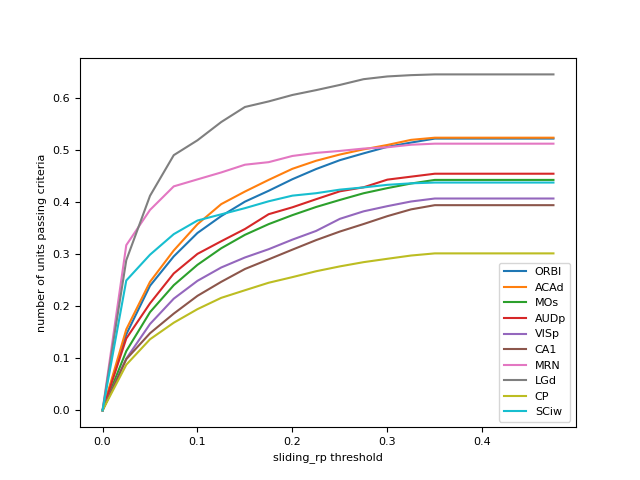

In [6]:
#plot how changing the sliding_rp threshold affects the number of units that pass the criteria

areas=['ORBl','ACAd','MOs','AUDp','VISp','CA1','MRN','LGd','CP','SCiw',]

sliding_rp_thresholds=np.arange(0,0.5,0.025)
fig,ax=plt.subplots(1,1)
for aa in areas:
    
    area_df=metrics_per_area_df.query('area==@aa')

    area_sliding_rp=(area_df['sliding_rp_plus_array']/area_df['n_units_no_criteria']).mean()

    ax.plot(sliding_rp_thresholds,area_sliding_rp,label=aa)
    
ax.set_xlabel('sliding_rp threshold')
ax.set_ylabel('number of units passing criteria')
# ax.set_title(f"area {aa}")
ax.legend()

# fig.savefig(os.path.join(savepath,f"{aa.replace('/','-')}_sliding_rp_threshold.png"))
# plt.close(fig)